In [1]:
import numpy as np
from utils import *

from skimage.color import rgb2gray
from PIL import Image
from scipy.signal import convolve2d
from scipy.ndimage import rank_filter
from scipy.stats import norm
from skimage import transform
import matplotlib
from matplotlib import pyplot as plt
import cv2
import math
import random
import pickle

SEED = 17
random.seed(SEED)
np.random.seed(SEED)

1. [5 points] Load both images, convert to double and to grayscale.

In [2]:
def loadGrayscaleImage(path):
    img = np.asarray(Image.open(path), dtype=np.float64)
    img_gray = rgb2gray(img)
    return img_gray

left = loadGrayscaleImage('./data/uttower_left.JPG')
left *= (255.0 / np.max(left))
right = loadGrayscaleImage('./data/uttower_right.JPG')
right *= (255.0 / np.max(right))

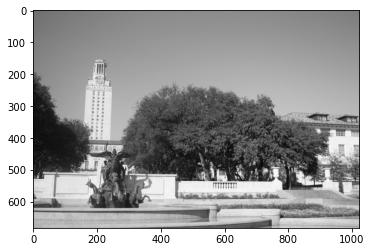

In [3]:
plt.imshow(left, cmap='gray')

2. [5 points] Detect feature points in both images. You can use harris.m for Harris corner detection.

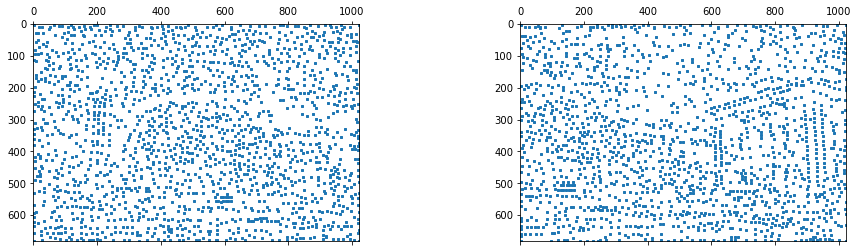

In [4]:
sigma = 3.2
thres = 2
r = 3

left_corners, left_r, left_c = harris(left, sigma, thresh=thres, radius=r)
right_corners, right_r, right_c = harris(right, sigma, thresh=thres, radius=r)

fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].spy(left_corners, markersize=2)
ax[1].spy(right_corners, markersize=2)

3. [10 points] Extract local neighborhoods around every keypoint in both images, and form descriptors simply by "flattening" the pixel values in each neighborhood to one-dimensional vectors. Experiment with different neighborhood sizes to see which one works the best.

In [5]:
h, w = left_corners.shape
left_circles = np.vstack([
    left_r,
    left_c,
    r * np.ones(left_r.shape[0])
]).T
right_circles = np.vstack([
    right_r,
    right_c,
    r * np.ones(right_r.shape[0])
]).T

left_sift = find_sift(left_corners, left_circles)
right_sift = find_sift(right_corners, right_circles)
left_sift.shape

(1779, 128)

4. [10 points] Compute distances between every descriptor in one image and every descriptor in the other image. You can use dist2.m for fast computation of Euclidean distance. Alternatively, experiment with computing normalized correlation, or Euclidean distance after normalizing all descriptors to have zero mean and unit standard deviation. Optionally, feel free to experiment with SIFT descriptors. Here is some find_sift.m for computing SIFT descriptors of circular regions.

In [6]:
distance = dist2(left_sift, right_sift)
distance.shape

(1663, 1779)

5. [10 points] Select putative matches based on the matrix of pairwise descriptor distances obtained above. You can select all pairs whose descriptor distances are below a specified threshold, or select the top few hundred descriptor pairs with the smallest pairwise distances.

In [7]:
def margsort(m):
    m = m.T  # we want the first column to be left image and second to be right
    idx_arr = np.argsort(m.ravel())
    idx_pairs = np.dstack(np.unravel_index(idx_arr, m.shape))
    return np.squeeze(idx_pairs, 0)

descriptor_pairs = margsort(distance)
descriptor_pairs.shape

(2958477, 2)

6. [40 points] Run RANSAC to estimate a homography mapping one image onto the other. You need to write the code for RANSAC by yourself. Report the number of inliers and the average residual for the inliers (squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Also, display the locations of inlier matches in both images.

In [8]:
def computeHomography(img1_coord, img2_coord):
    '''Direct Linear Transforms'''
    n = img1_coord.shape[0]
    A = np.zeros((n * 2, 9))
    for i in range(n):
        x, y = img1_coord[i]
        xp, yp = img2_coord[i]
        A[i*2] = np.array([x, y, 1, 0, 0, 0, -xp * x, -xp * y, -xp])
        A[i*2+1] = np.array([0, 0, 0, x, y, 1, -yp * x, -yp * y, -yp])
    
    eigval, eigvec = np.linalg.eig(A.T @ A)
    # u, s, vh = np.linalg.svd(A)
    h_hat = eigvec[:, np.argmin(eigval)]
    # print(A @ h_hat)
    return np.reshape(h_hat, (3, 3))

def predictCoord(H, coord_in):
    pred = np.zeros_like(coord_in)
    
    for i in range(coord_in.shape[0]):
        cin = np.append(coord_in[i], 1)
        xp = (H[0] @ cin) / (H[2] @ cin)
        yp = (H[1] @ cin) / (H[2] @ cin)
        pred[i] = np.array([xp, yp])
    
    return pred

def getInliers(H, img1_coord, img2_coord, thres=10):
    inliers = [[], []]
    pred = predictCoord(H, img1_coord)
    for i in range(img2_coord.shape[0]):
        if np.linalg.norm(pred[i] - img2_coord[i]) < thres:
            inliers[0].append(img1_coord[i])
            inliers[1].append(img2_coord[i])
    inliers[0] = np.array(inliers[0])
    inliers[1] = np.array(inliers[1])
    return inliers

def RANSAC(pairs, lcoord, rcoord, N=10, thres=100):
    inliers = [np.array([]), np.array([])]
    
    for i in range(N):
        # get a sample of 4 pair of descriptors
        sample_indices = np.random.randint(0, pairs.shape[0], size=4)
        coord_img1 = np.zeros((4, 2))
        coord_img2 = np.zeros((4, 2))
        for i, idx in enumerate(sample_indices):
            idx1, idx2 = pairs[idx]
            coord_img1[i] = lcoord[idx1]
            coord_img2[i] = rcoord[idx2]
        
        H = computeHomography(coord_img1, coord_img2)
        curr_inliers = getInliers(H, lcoord, rcoord, thres)
        
        # Keep largest set of inliers
        if curr_inliers[0].shape[0] > inliers[0].shape[0]:
            inliers = curr_inliers
            
    # Re-compute least-squares H estimate
    # using all of the inliers
    # return H
    return computeHomography(inliers[0], inliers[1]), inliers

In [9]:
H, inliers = RANSAC(descriptor_pairs, left_circles[:,:2], right_circles[:,:2], N=10000, thres=20)
H

/var/folders/tc/kg28gjm16xgc5t5lyfvh_5sw0000gn/T/ipykernel_62891/545442076.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  pred[i] = np.array([xp, yp])


array([[ 1.59888990e-03, -8.81203788e-04,  8.48134862e-01],
       [-8.10407661e-04,  9.07179045e-04,  5.29765230e-01],
       [ 1.68135082e-07, -2.04841419e-06,  3.35319821e-03]])

In [10]:
pickle.dump(H, open('./model/Homography.p', 'wb'))
pickle.dump(inliers, open('./model/inliers.p', 'wb'))

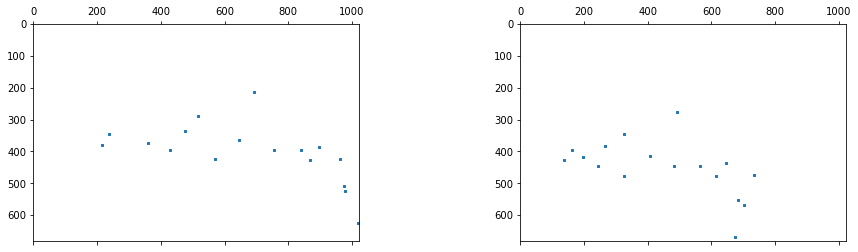

In [11]:
left_inliers = np.zeros_like(left, dtype=np.bool_)
right_inliers = np.zeros_like(right, dtype=np.bool_)
for i in range(inliers[0].shape[0]):
    left_x, left_y = inliers[0][i]
    right_x, right_y = inliers[1][i]
    left_inliers[int(left_x), int(left_y)] = True
    right_inliers[int(right_x), int(right_y)] = True

fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].spy(left_inliers, markersize=2)
ax[1].spy(right_inliers, markersize=2)

7. [10 points] Warp one image onto the other using the estimated transformation. To do this, you will need to learn about `maketform` and `imtransform` functions in MATLAB or similar functions in Python. You can use off-the-shelf code for this transformation (warping).

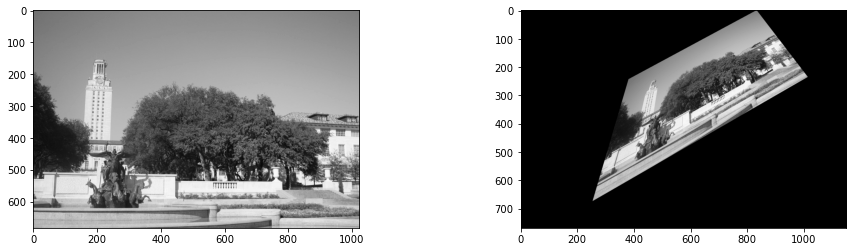

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (16,4))
ax[0].imshow(left, cmap='gray')
ax[1].imshow(warp_image(left, H), cmap='gray')